## Cat Dog Classifier
#### J-A-Collins

In [1]:
from fastbook import *
from fastai.vision.widgets import *

There are a bunch of misconceptions about deep-learning. The ones I notice the most are:

1. You need to be good at lots of hyper-complicated mathematics
2. You need huge amounts of data
3. You need to own an extremely expensive computer
4. You need to have a strong academic background, in particular, PhD level education

These are all untrue. I'm sure some of them kind of help or make life easier _sometimes_ but really you can put a lot of this aside and start building or hi-jacking some other pretrained models that might be fit for your needs. One of the most frustrating things I encounter in my working life is how much time is spent focusing on theory rather than actually just making stuff. I'm a scientist first and a data scientist second. What's the difference? I want to **experiment**. I want to try things, make observations and then get on to the next iteration. Theory is great, I love it when I'm in a lecture hall, but most of my life is spent at home or at work and I want to _do_ stuff. In this notebook, I want to show how points 1-4 aren't required when I build an image classifier. My aim is to build a model that I can then provide input images of a dog or a cat and it will classify them. I'll use fastai to show how quick and easy deep learning computer vision can be.


## Data Collection
Kaggle, Google, the Bing api, js in your browser. Whatever, there are loads of ways to get lots of data. I've just gone to kaggle, downloaded a dataset of images of the things I need. The sets were in the thousands of images. That's amazing but I'll just take 150 or so of each. In most data scientists view, that's a stupidly small amount of data.

In [2]:
path = Path('images')

Check that our folder has image files

In [3]:
fns = get_image_files(path)
fns

(#300) [Path('images/cat/cat_1.jpg'),Path('images/cat/cat_10.jpg'),Path('images/cat/cat_100.jpg'),Path('images/cat/cat_101.jpg'),Path('images/cat/cat_102.jpg'),Path('images/cat/cat_103.jpg'),Path('images/cat/cat_104.jpg'),Path('images/cat/cat_105.jpg'),Path('images/cat/cat_106.jpg'),Path('images/cat/cat_107.jpg')...]

This is a good point to mention my first issue with data collection, bias and image classification:

**MODELS REFLECT THE DATA THEY ARE TRAINED ON**

The world is full of biased data and this ends up reflected in the means we use to gather data. Let's look at an example. I want to make an app that can help people figure out whether they had a healthy body (whatever that is) and we train our model on images from online search results for 'healthy body'. Let's see what we get...

<img src="body.JPG" width="600" caption="Data for a healthy body?" id="healthy_body">

If we use this as our training set, we will probably end up with a young, brunette, white woman detector mostly. We should all think carefully about the types of data that we might expect to see in practice in our models, and check carefully to ensure that all these types are reflected in the model's source data

Anyway, now that we have data, we need to format it so that it's suitable for model training. I've made a folder called `images`. Inside it has a `cat` folder for images of cats, and a `dog` folder for images of dogs. We create an DataLoaders object now.

`DataLoaders` just stores objects you pass to it, and makes them available as `train` and `valid` sets. I'll comment each line to explain what it's doing.

In [4]:
animals = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # tuple specifying what types we want for the independent and dependent variables
    # The independent variable is the thing we are using to make predictions from - images in this case.
    # the dependent variable is our target - the category of the image, in this case cat or dog.
    get_items=get_image_files, # our underlying items which will be file paths
    # We use `get_image_files` to take a path, and returns a list of all of the images in that path
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # Split our training and validation sets randomly
    get_y=parent_label, # The function that will extract the dependent variable from the file path
    item_tfms=Resize(128))  # A transform which resizes the images to the same size

In [5]:
dls = animals.dataloaders(path)

`DataLoader` provides batches of a few items at a time to the GPU. It'll stack 64 items at a time into a single tensor. We can look at a few by calling the `show_batch` method on the `DataLoader` object:

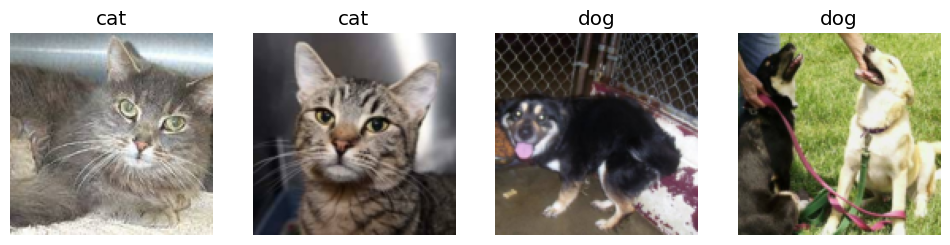

In [6]:
dls.valid.show_batch(max_n=4, nrows=1)

`Resize` crops the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. We can pad the images with zeros or stretch them:

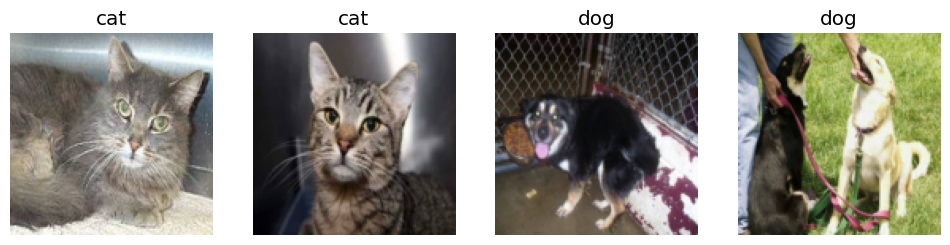

In [7]:
animals = animals.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = animals.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

I mention these tools because an entirely untrained neural network knows nothing whatsoever about how images behave. It doesn't even recognize that when an object is rotated by one degree, it still is a picture of the same thing. So training the neural network with examples of images where the objects are in slightly different places and slightly different sizes helps it to understand the basic concept of what an object is, and how it can be represented within an image.

We can replace `Resize` with `RandomResizedCrop`, which is the transform that provides the behavior I just described. `min_scale` determines how much of the image to select at minimum each time:

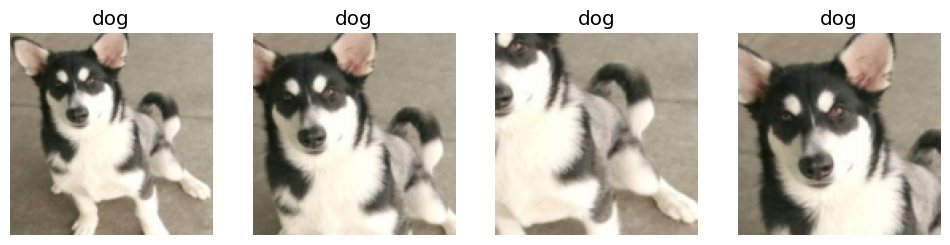

In [8]:
animals = animals.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = animals.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

Data augmentation is the process of creating random variations of our input data, so that they appear different, but do not actually change the meaning of the data. Examples of augmentation: rotation, flipping, perspective warping, brightness changes and contrast changes

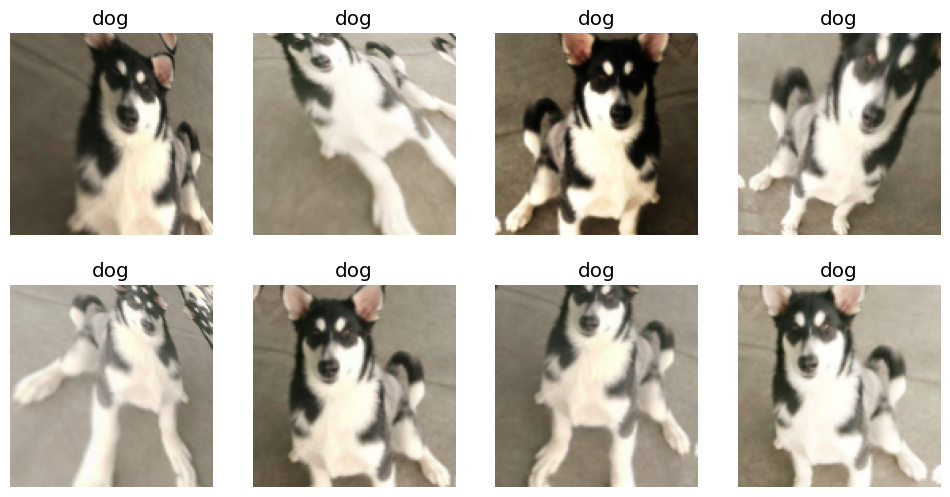

In [9]:
# Augmentation
animals = animals.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = animals.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## We can train our model now and use it to clean our data
It's a weird idea, I know, but let's see how it goes. We don't have a lot of data for this problem (150 pictures od cats and 150 of dogs), so to train our model, we'll use RandomResizedCrop with an image size of 224 pixels, which is fairly standard for image classification, and default aug_transforms:

In [10]:
animals = animals.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = animals.dataloaders(path)

Now we train or fit the model:

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

c:\DevTools\anaconda3\envs\cudavenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\DevTools\anaconda3\envs\cudavenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Now we can examine the mistakes the model is making using a confusion matrix:

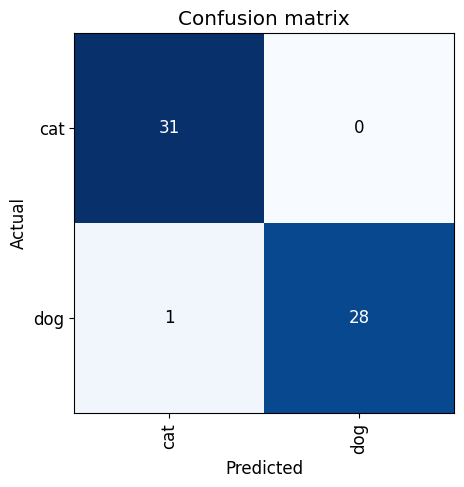

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The rows represent all the cats and dogs in our dataset, respectively. The columns represent the images which the model predicted as cat and dog, respectively. So you can see, the diagonal of the matrix shows the images which were classified correctly, and the off-diagonal cells represent those which were classified incorrectly. This is calculated using the validation set. Only one mistake.

It's helpful to see where errors occur, to see whether they're due to a dataset problem (e.g., images that are labeled incorrectly, etc.), or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a weird angle, etc.). We can do this by sorting our images by their loss.

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. Each image is labeled with four things: prediction, actual (the target label), loss, and probability.

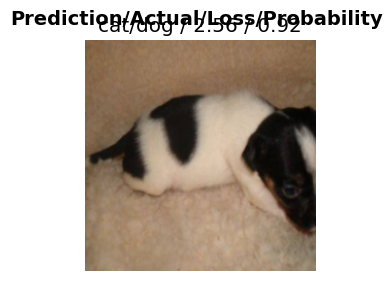

In [13]:
# Let's find the weird image
interp.plot_top_losses(1, nrows=1)

The intuitive approach to doing data cleansing is to do it _before_ you train a model. But, as you can see, a model can actually help you find data issues more quickly and easily. So, why not train a quick and simple model first, and then use it to help us with data cleaning? In this case I can see the image is somewhat obscured, the body is surprisingly cat-like. I an use the cleaner a delete the image now.

In [14]:
# cleaner = ImageClassifierCleaner(learn)
# cleaner

## Deploy it
Now we can save the model, copy it over to a server and use it in production. Remember that a model consists of two parts: the *architecture* and the trained *parameters*. The simplest way to save the model is to save both parts. This way when the model is loaded, we can be sure that the matching architecture and parameters are used together. I'll use the `export` method to create a pickle file of both parts:

In [15]:
learn.export()

In [16]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [17]:
learn_inf = load_learner(path/'export.pkl')

In [18]:
learn_inf.predict('animal.jpg')

('dog', TensorBase(1), TensorBase([1.6445e-05, 9.9998e-01]))

This has returned:
1. The predicted category in the same format we originally provided (a string), 
2. The index of the predicted category; and
3. The probabilities of each category

In [19]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [20]:
btn_upload = SimpleNamespace(data = ['animal.jpg'])

In [21]:
# img = PILImage.create(btn_upload.data[-1])
img = Image.open("animal.jpg")

In [22]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img)
out_pl

Output()

In [23]:
pred, pred_idx, probs = learn_inf.predict(img)

In [24]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: dog; Probability: 1.0000')

In [25]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [26]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [29]:
btn_upload = widgets.FileUpload()

In [30]:
VBox([widgets.Label('Select your dog or cat!'), 
      btn_upload, btn_run, out_pl, lbl_pred])